# DELIVERY TIME PREDICTION FOR AN E-COMMERCE PLATFORM

### Importing the required libraries

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, explained_variance_score


from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adamax, RMSprop
from tensorflow.keras.models import Sequential
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

### Importing Data

In [6]:
df_ = pd.read_csv(r'C:/Users/ecommerceData.csv', sep=',')

In [8]:
df_.head()

,b2c_c2c,seller_id,declared_handling_days,acceptance_scan_timestamp,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,item_zip,buyer_zip,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,record_number
0,B2C,10908,2.0,2019-01-29 21:06:00.000-08:00,1,0.0,2,5,92647-2556,33166,0,57.95,1,2019-01-29 08:53:07.000-08:00,2019-02-01,0,1,PACKAGE_THICK_ENVELOPE,2439590
1,C2C,157755,1.0,2019-01-28 15:09:00.000-06:00,0,0.0,3,5,53059,71251,17,7.99,1,2019-01-27 13:55:48.000-06:00,2019-02-01,4,1,PACKAGE_THICK_ENVELOPE,6819491
2,C2C,114339,3.0,2019-01-28 21:22:00.000-08:00,3,3.0,2,8,92652,70508,14,20.00,1,2019-01-23 05:06:39.000-08:00,2019-02-01,16,1,PACKAGE_THICK_ENVELOPE,12910043
3,B2C,8661,1.0,2019-01-29 18:13:00.000-05:00,0,0.0,3,5,33122,92509,5,228.90,1,2019-01-28 16:41:00.000-05:00,2019-02-01,13,1,PACKAGE_THICK_ENVELOPE,10762342
4,B2C,2020,0.0,2019-01-29 16:46:00.000-05:00,0,0.0,3,5,02124,93727,11,15.99,1,2019-01-28 18:51:17.000-05:00,2019-02-01,3,1,PACKAGE_THICK_ENVELOPE,242198


### Exploratory Data Analysis

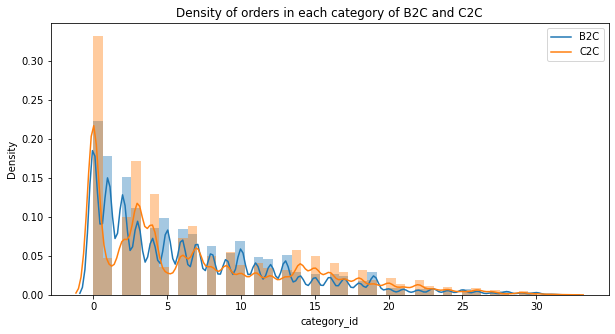

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(df_['category_id'][df_['b2c_c2c']=='B2C'])
sns.distplot(df_['category_id'][df_['b2c_c2c']=='C2C'])

plt.title('Density of orders in each category of B2C and C2C')
plt.legend(['B2C', 'C2C'])
plt.show()

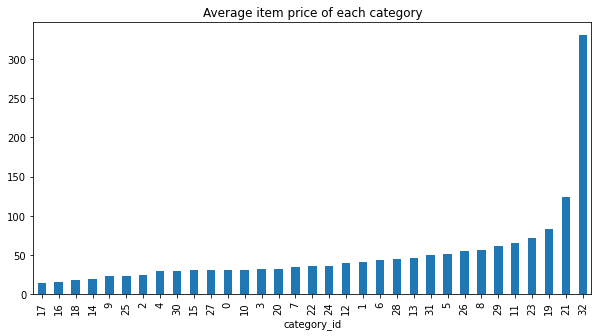

In [11]:
plt.figure(figsize=(10,5))
df_.groupby('category_id')['item_price'].mean().sort_values().plot(kind='bar')
plt.title('Average item price of each category')
plt.show()

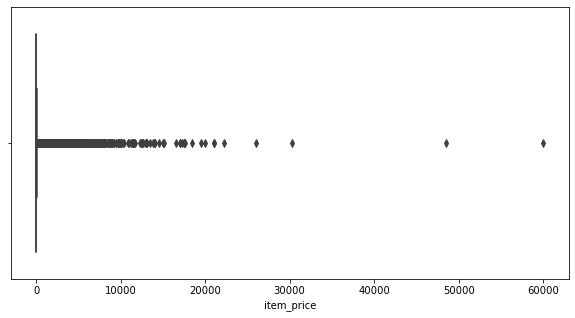

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x='item_price', data=df_)
plt.show()

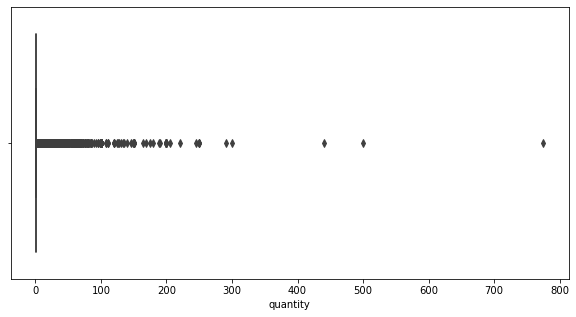

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x='quantity', data=df_)

plt.show()

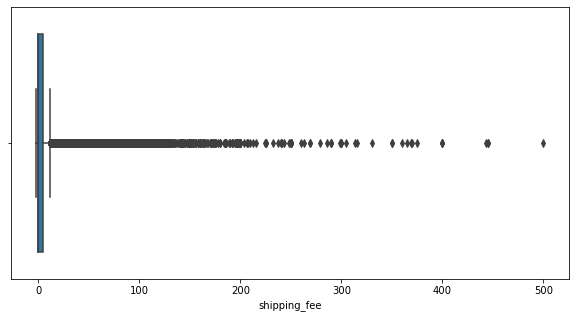

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(x='shipping_fee', data=df_)
plt.show()

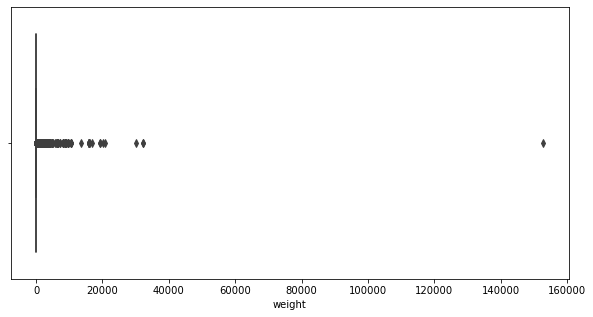

In [56]:
plt.figure(figsize=(10,5))
sns.boxplot(x='weight', data=df_)
plt.show()

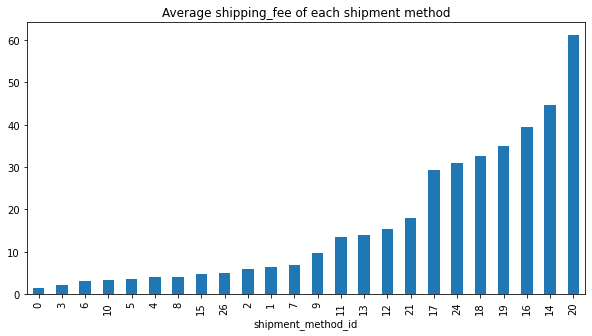

In [15]:
plt.figure(figsize=(10,5))
df_.groupby('shipment_method_id')['shipping_fee'].mean().sort_values().plot(kind='bar')
plt.title('Average shipping_fee of each shipment method')
plt.show()

### Data Preprocessing

In [16]:
#Converting all weights to pounds
df_['weight'][df_['weight_units']==2] = df_['weight']*2.2

In [17]:
#Computing the mean of Declared Handling Days by seller_id
tempdf = df_.groupby('seller_id')['declared_handling_days'].mean()

In [18]:
result = pd.merge(df_, tempdf, on = 'seller_id')

In [19]:
#Filling the NaN values of Declared handling days with the mean of Declared handling days by seller_id
result.declared_handling_days_x = result.declared_handling_days_x.fillna(np.floor(result.declared_handling_days_y)) #fill in missing values if indices match

In [21]:
result.declared_handling_days_x = result.declared_handling_days_x.fillna(1) ##declared handling days for NaN is assumed to be 1

In [22]:
df_ = result

In [23]:
#Date is extracted from Acceptance scan timestamp
df_['acceptance_scan_timestamp'] = pd.to_datetime(df_['acceptance_scan_timestamp'], utc=True)
df_['ast'] = pd.to_datetime(df_['acceptance_scan_timestamp']).dt.date

In [24]:
#Calculation of Acceptance Days = Acceptance Date - Payment Datetime
df_['acceptance_days'] = pd.to_datetime(df_['ast'], utc=True) - pd.to_datetime(df_['payment_datetime'], utc=True)
df_['acceptance_days'] = df_['acceptance_days'].dt.days

In [25]:
#Calculation of Season = (Acceptance scan timestamp - 1) // 3
#to classify seasons as 1,2,3 to 0 (winter), 4,5,6 to 1 (spring), 7,8,9 to 2 (summer), and 10,11,12 to 3 (fall)
season = (df_['acceptance_scan_timestamp'].dt.month - 1) // 3 
df_['season'] = season

In [26]:
#Calculation of Delivery Days = Delivery Date - Payment Datetime
df_['delivery_date'] = pd.to_datetime(df_['delivery_date'], utc=True)
df_['delivery_days'] = df_['delivery_date'] - pd.to_datetime(df_['payment_datetime'], utc=True)
df_['delivery_days'] = df_['delivery_days'].dt.days

In [27]:
#Calculation of mean of Carrier field
df_['carrier_mean'] = (df_['carrier_min_estimate'] + df_['carrier_max_estimate'])/2

In [28]:
#Selecting the entries with acceptance days greater than -2
df_ = df_[df_['acceptance_days']>-2]

In [29]:
#Dropping the entries if Payment Datetime is greater than Delivery Date
payment_delivery = df_[pd.to_datetime(df_['delivery_date']).dt.date < pd.to_datetime(df_['payment_datetime'], utc=True).dt.date]
new_df_ = df_.drop(payment_delivery.index)
new_df_['day'] = pd.to_datetime(new_df_['payment_datetime'], utc=True).dt.dayofweek

In [30]:
#Dropping unwanted and redundant fields - 'weight_units', 'record_number', 'delivery_date','ast' ,'declared_handling_days_y', 'carrier_min_estimate', 'carrier_max_estimate'
new_df_.drop([ 'weight_units', 'record_number', 'delivery_date','ast' ,'declared_handling_days_y', 'carrier_min_estimate', 'carrier_max_estimate'], axis=1, inplace=True)

In [32]:
#Rounding up to 4 decimal spaces all the numbers in the Dataframe
new_df_ = new_df_.round(4)
df_train = new_df_

In [34]:
#Taking Delivery days as the y predicting factor, dropping it from X
X = df_train.drop('delivery_days', axis=1)
y = df_train['delivery_days']

### Label Encoding and Standardization

In [37]:
# Label Encoding the categorical data
le = LabelEncoder()
columns = ['b2c_c2c', 'seller_id', 'acceptance_scan_timestamp', 'item_zip', 
           'buyer_zip', 'payment_datetime', 'package_size']
for col in columns:
    X[col] = le.fit_transform(X[col])

# Standardizing the features so that the data is distributed uniformly
X = StandardScaler().fit_transform(X)

In [38]:
# splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Model Building

### Random Forest Model

In [39]:
regr = RandomForestRegressor(n_estimators=200, max_depth = 1, random_state=21, min_samples_split = 2)
regr.fit(x_train, y_train)
predictions = regr.predict(x_test)

In [60]:
print('R2 Score: ', r2_score(y_test, np.floor(predictions)))
print('Explained variance score: ',explained_variance_score(y_test,np.floor(predictions)))

R2 Score:  0.3603498691505749
Explained variance score:  0.36878103220785396


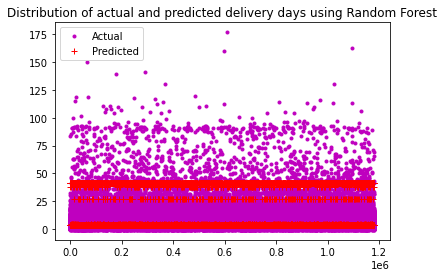

In [71]:
plt.plot(range(len(y_test)), y_test,'m.', label='Actual')
plt.plot(range(len(y_test)), predictions,'r+', label='Predicted')
plt.title('Distribution of actual and predicted delivery days using Random Forest')
plt.legend()
plt.show()

### XGBoost Model

In [43]:
model = XGBRegressor(n_estimators=500, random_state=42)

eval_set = [(x_train, y_train), (x_test, y_test)]
eval_metric = ["rmse"]

%time model.fit(x_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

Wall time: 31min 37s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [ ]:
# final model assessment
pred_test = np.floor(model.predict(x_test))
pred_train = np.floor(model.predict(x_train))

In [63]:
print('R2 Score: ', r2_score(y_test, pred_test))
print('Explained variance score: ',explained_variance_score(y_test,pred_test))

R2 Score:  0.7534350238231595
Explained variance score:  0.776798439252947


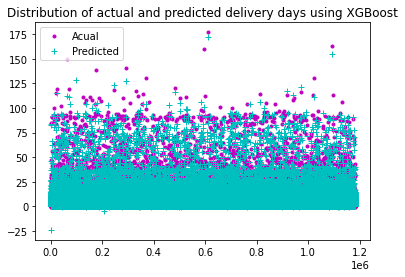

In [70]:
plt.plot(range(len(y_test)), y_test,'m.', label='Acual')
plt.plot(range(len(y_test)), pred_test,'c+', label='Predicted')
plt.title('Distribution of actual and predicted delivery days using XGBoost')
plt.legend()
plt.show()

### Neural Network Model

In [ ]:
model_nn = Sequential()

model_nn.add(Dense(128, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(64, kernel_initializer='normal', activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(24, kernel_initializer='normal', activation='relu'))
model_nn.add(Dense(1, activation='relu'))

model_nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = model_nn.fit(x_train, y_train, epochs=15, batch_size=128, validation_data=(x_test, y_test), verbose=0)


pred_test1 = np.floor(model_nn.predict(x_test))
pred_train1 = np.floor(model_nn.predict(x_train))

In [59]:
# Model Metrics
print('R2 Score: ', r2_score(y_test, pred_test1))
print('Explained variance score: ',explained_variance_score(y_test,pred_test1))

R2 Score:  0.7264897798396919
Explained variance score:  0.7460836530944905


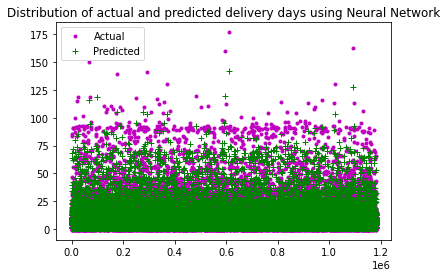

In [69]:
plt.plot(range(len(y_test)), y_test,'m.', label='Actual')
plt.plot(range(len(y_test)), pred_test1,'g+', label='Predicted')
plt.title('Distribution of actual and predicted delivery days using Neural Network')
plt.legend()
plt.show()

In [58]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2432      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 12,273
Trainable params: 12,273
Non-traina

### ADA Boost Model

In [ ]:
abr = AdaBoostRegressor(random_state=21, n_estimators=100)
abr.fit(x_train, y_train)
pred_testabr = np.floor(abr.predict(x_test))
pred_trainabr = np.floor(abr.predict(x_train))

In [66]:
print('R2 Score: ', r2_score(y_test, pred_testabr))
print('Explained variance score: ',explained_variance_score(y_test,pred_testabr))

R2 Score:  0.5066281076096044
Explained variance score:  0.594634774812475


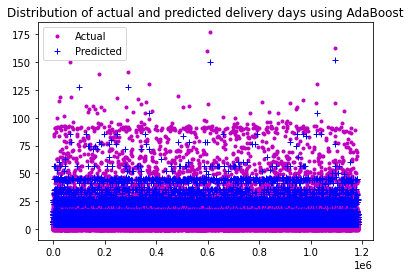

In [68]:
plt.plot(range(len(y_test)), y_test,'m.', label='Actual')
plt.plot(range(len(y_test)), pred_testabr,'b+', label='Predicted')
plt.title('Distribution of actual and predicted delivery days using AdaBoost')
plt.legend()
plt.show()

##### Observation: XGBoost Regressor produces the best results for the prediction of delivery dates for an e-commerce platform with real-time data.

### ---------------End of the Program------------------